In [1]:
from forward import solve_forward
from simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# to load large .mat files
import mat73
import random
from net import EEG_CNN

2021-12-21 00:39:18.852177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 00:39:18.852209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Train the CNN

In [2]:
eeg_topos = mat73.loadmat('/media/thanos/Elements/thanos/sim_data/sim_type_1/eeg_topos_2TeD.mat')['eeg_topos']
eeg_topos = eeg_topos.transpose(2, 0, 1)

Text(0.5, 1.0, 'Topography for eeg signal: 64013')

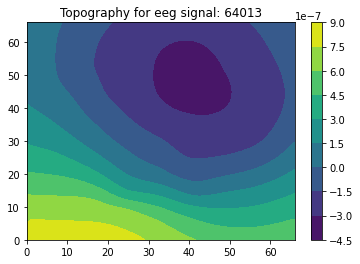

In [3]:
topo_idx = random.randint(0,eeg_topos.shape[0]-1)
topo = eeg_topos[topo_idx,:,:]
plt.contourf(topo, cmap=cm.get_cmap('viridis'))
cbar = plt.colorbar()
plt.draw()
plt.title('Topography for eeg signal: {}'.format(topo_idx+1))

In [4]:
# load previous simulation
sources = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/sources_2TeD.npy')
eeg = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/eeg_2TeD.npy')

fwd = solve_forward()
sim = Simulation(fwd=fwd, source_data=sources, eeg_data=eeg)
# fwd = solve_forward()
# sim = Simulation(fwd=fwd)
# sim.simulate(n_samples=100)

Forward problem is solved.
Electrodes: (73, 3)
Dipoles: (50460, 3)
Leadfield: (73, 50460)


In [5]:
eegcnn = EEG_CNN(sim=sim, eeg_topographies=eeg_topos)

In [6]:
eegcnn.build_model()

2021-12-21 00:48:54.001863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 00:48:54.002969: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 00:48:54.004210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanos): /proc/driver/nvidia/version does not exist
2021-12-21 00:48:54.021387: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 00:48:54.853436: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 276889600 exceeds 10

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 65, 32)        320       
                                                                 
 flatten (Flatten)           (None, 135200)            0         
                                                                 
 dense (Dense)               (None, 512)               69222912  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [7]:
eegcnn.fit(epochs=120, patience=35, batch_size=128)

Epoch 1/120
631/631 [==============================] - 1539s 2s/step - loss: 0.0029 - val_loss: 0.0023
Epoch 2/120
631/631 [==============================] - 1497s 2s/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/120
631/631 [==============================] - 1538s 2s/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/120
631/631 [==============================] - 1515s 2s/step - loss: 8.5222e-04 - val_loss: 9.3354e-04
Epoch 5/120
631/631 [==============================] - 1445s 2s/step - loss: 7.0316e-04 - val_loss: 7.4371e-04
Epoch 6/120
631/631 [==============================] - 1416s 2s/step - loss: 6.0063e-04 - val_loss: 7.9645e-04
Epoch 7/120
631/631 [==============================] - 1453s 2s/step - loss: 5.3881e-04 - val_loss: 7.1278e-04
Epoch 8/120
631/631 [==============================] - 1478s 2s/step - loss: 4.9099e-04 - val_loss: 5.1407e-04
Epoch 9/120
631/631 [==============================] - 1502s 2s/step - loss: 4.5495e-04 - val_loss: 5.7648e-04
Epoch 10/120
631/631 [===

(<keras.callbacks.History at 0x7f01ccae3ca0>,
 'logs/CNN-Model-21_12_2021__00:39:21')

In [8]:
eegcnn.save_nn('../cnn_model.h5')

### Evaluate the CNN

In [ ]:
eegcnn.load_nn('/media/thanos/Elements/thanos/nn_trained/cnn_model.h5')

In [9]:
eeg_topos_eval = mat73.loadmat('/media/thanos/Elements/thanos/sim_data/sim_type_1/eval_100/eeg_topos_eval_100.mat')['eeg_topos']
eeg_topos_eval = eeg_topos_eval.transpose(2, 0, 1)

sources_eval = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/eval_100/sources.npy')


In [10]:
predicted_sources = eegcnn.predict(eeg=eeg_topos_eval).T

In [11]:
np.save('../../Downloads/predicted_sources.npy',predicted_sources)